# Surface Mass Balance: XGB 

Import relevant Libaries 

In [ ]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
#%pip update pandas

In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

## Load Stations

In [ ]:
# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
#input_path = r'../data/promice/preprocessed/South_West/'
input_path = r'../data/promice/preprocessed/North_East/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'
#staion_list = ['SCO_L.csv','KAN_L.csv']

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

df = df.reset_index(drop=True)

df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

In [ ]:
df = df[df['stid'] != 'NUK_U']
df = df[df['stid'] != 'QAS_U']
df = df[df['stid'] != 'SCO_U']
df = df[df['stid'] != 'KPC_L']

In [118]:
# Load Unique Stations
station_list = pd.read_csv(r'../data/promice/stations.csv')

# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = r'../data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

In [119]:
df = df[df['stid'] == 'SCO_L']

In [3]:
stationss = ['KPC_L',
'SCO_L',
'SCO_U',
'THU_L',
'UPE_L',
'UPE_U',
'MIT',
'TAS_L',
'KAN_L',
'NUK_L',
'NUK_U',
'QAS_L',
'QAS_U',]

df = df[df['stid'].isin(stationss)]

## melt onset day / melt end day detection

In [120]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True

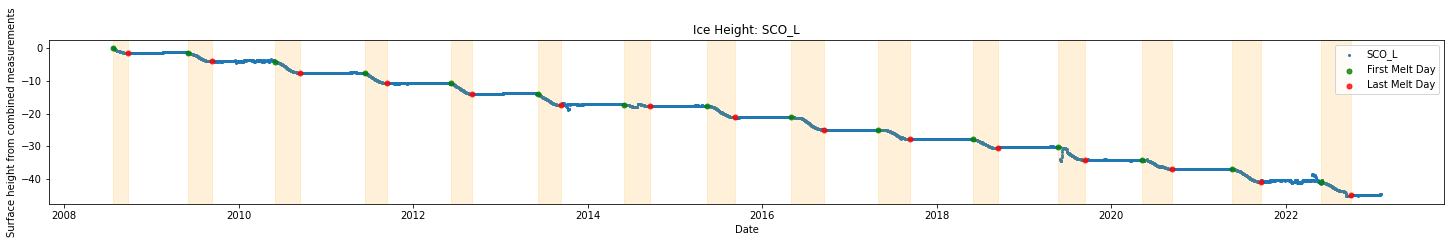

In [121]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = station_df[station_df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['Surface height from combined measurements'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'Surface height from combined measurements'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'Surface height from combined measurements'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Ice Height: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Surface height from combined measurements')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'Surface_Height_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()
    

## Time Series Decomposition

In [122]:
# https://datastud.dev/posts/python-seasonality-how-to

In [123]:
# This bit to decompose for each station
df = df[df['stid'] != 'QAS_Lv3']
df = df[df['stid'] != 'Roof_PROMICE']
df = df[df['stid'] != 'LYN_L']
df = df[df['stid'] != 'LYN_T']
df = df[df['stid'] != 'KPC_Lv3']
df = df[df['stid'] != 'KPC_Uv3']
df = df[df['stid'] != 'JAR_O']
df = df[df['stid'] != 'SWC_O']
df = df[df['stid'] != 'THU_L2']
df = df[df['stid'] != 'Roof_GEUS']
df = df[df['stid'] != 'ZAK_Uv3']
df = df[df['stid'] != 'WEG_B']


df = df[df['Surface height from combined measurements'].notna()] 

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i)
        

In [124]:
# This bit to add decomposition to df and smooth the residual component
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    #df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [125]:
# This bit to generate the periods that we want to focus on
df['seasonal'] = df['seasonal'].astype(float)
# create a new column to store the periods
df['Periods'] = ''

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    # iterate over each year in the dataframe
    for year in df_station['Datetime'].dt.year.unique():
        year_data = df_station[df_station['Datetime'].dt.year == year]
        if len(year_data.index) > 300:
            max_index = year_data['seasonal'].idxmax()
            min_index = year_data['seasonal'].idxmin()

            # set the periods in the new column for the maximum value
            df.loc[max_index-5:max_index, 'Periods'] = 'pre_max'
            df.loc[max_index:max_index+6, 'Periods'] = 'post_max'

            # set the periods in the new column for the minimum value
            df.loc[min_index-5:min_index, 'Periods'] = 'pre_min'
            df.loc[min_index:min_index+6, 'Periods'] = 'post_min'
        else:
            continue 

In [126]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df, station):
    """Plot data for initial visualization
    Args:
        df (pandas dataframe)
    """
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual ]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,20))

    #plt.subplot(4,1,1)
    #plt.title("Original Data")
    #plt.ylim(ymin, ymax)
    #plt.plot(df.index, df.observed)

    plt.subplot(4,1,1)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,2)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,3)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)
    
    plt.subplot(4,1,4)
    plt.title("residual_smoothed")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual_smoothed)

    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

In [127]:
df["stid"].unique().tolist()

['SCO_L']

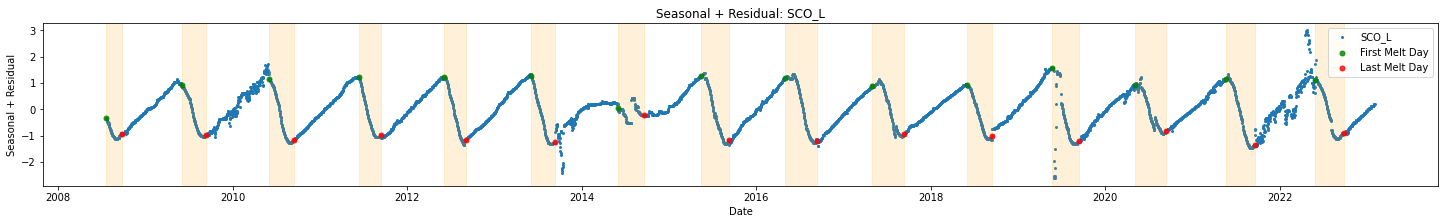

In [128]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = df[df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))

    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['seasonal_residual'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'seasonal_residual'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'seasonal_residual'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Seasonal + Residual: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Seasonal + Residual')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'seasonal_residual_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
    
plt.show()


In [129]:
def plt_seasonal_residual(df,station):
    df = df[df['stid'] == station]
    
    df_axis = df.fillna(0)
    ymin = np.round(np.min([df_axis.seasonal_residual]), 5) - 5
    ymax = np.round(np.max([df_axis.seasonal_residual]), 5) + 5

    plt.figure(figsize=(20,15))

    # Plot the seasonal_residual values
    plt.subplot(4,1,4)
    plt.title("seasonal_residual")
    plt.ylim(ymin, ymax)

    # Plot the pre_max values
   # pre_max_indices = df[df['Periods'] == 'pre_max'].index
   # plt.scatter(pre_max_indices, df.loc[pre_max_indices, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=20 )

    # Plot the post_max values
    #post_max_indices = df[df['Periods'] == 'post_max'].index
    #plt.scatter(post_max_indices, df.loc[post_max_indices, 'seasonal_residual'], c='g', marker='.', label='post_max',s=8)

    # Plot the pre_min values
    #pre_min_indices = df[df['Periods'] == 'pre_min'].index
    #plt.scatter(pre_min_indices, df.loc[pre_min_indices, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=8)

    # Plot the post_min values
    #post_min_indices = df[df['Periods'] == 'post_min'].index
    #plt.scatter(post_min_indices, df.loc[post_min_indices, 'seasonal_residual'], c='g', marker='.', label='post_min',s=8)

    plt.plot(df.index, df.seasonal_residual)#, c = "grey")

#plt_seasonal_residual(df,"SCO_L")


In [130]:
#plot_components(df, 'SCO_L')

## Regression Analysis

##### Set target variable

In [131]:
y = 'Surface height from combined measurements'

In [132]:
len(df)

5309

##### Pre-processing (0.1: Change months to cycle)

In [133]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
#df.drop(columns=['Datetime'], inplace=True)

In [134]:
len(df)

5309

In [135]:
#from feature_engine.creation import CyclicalFeatures

#cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
#df_wind = df[df['Wind from direction (upper boom)'].notna()]
#cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']])

# Reset the index for both dataframes
#df.reset_index(drop=True, inplace=True)
#cyclical_df.reset_index(drop=True, inplace=True)

# Update the original dataframe with the transformed wind columns
#for col in cyclical_df.columns:
#    df.loc[df_wind.index, col] = cyclical_df[col]


In [136]:
# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 

# Reset the index for cyclical_df
cyclical_df.reset_index(inplace=True)

# Merge the original df with the cyclical_df using a left join
df = pd.merge(df.reset_index(), cyclical_df, left_on='index', right_on='index', how='left')

# Drop the 'index' column and reset the index
#df.drop(columns=['index'], inplace=True)


In [137]:
len(df)

5309

##### Pre-processing (1.0: Filter relevant periods)

In [138]:
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#df =  df[df['Ablation'].isin([True])]

In [139]:
df = df[df[y].notna()] 

In [140]:
#df = df.reset_index(drop=True)

##### Pre-processing (2.0: Formatting and transformation)

In [141]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [146]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', 
                #'month',
                #'month_sin',
                #'month_cos',
                #'day', 
                #'day_sin',
                #'day_cos',
                'hour', 
                #'year',
                'year_sin',
                'year_cos'
                'subgroup',
                #'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                'DayOfYear',
                'Datetime',
                'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [143]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

Time horizon: 1 days


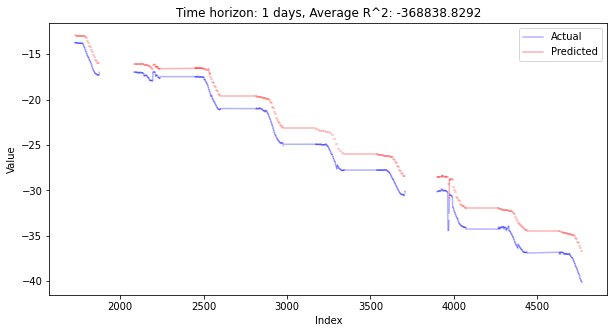

Average Mean Squared Error: 3.7972
Average Mean Absolute Error: 1.8414
Average R^2 Score: -368838.8292

Time horizon: 7 days


KeyboardInterrupt: 

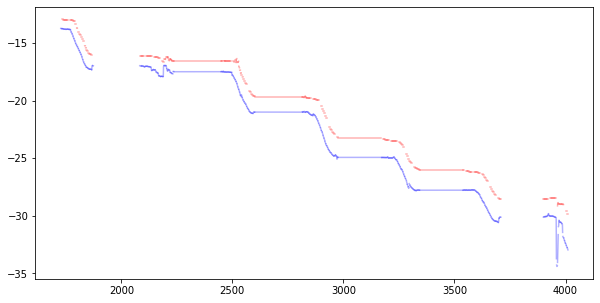

In [158]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

def create_target(df, target_col, horizon):
    df_shifted = df.shift(-horizon)
    df[f"{target_col}_{horizon}"] = df_shifted[target_col]
    return df

target_col = "Surface height from combined measurements"
horizons = [1, 7, 30]

for horizon in horizons:
    df = create_target(df, target_col, horizon)
def add_rolling_features(df, column, windows):
    for window in windows:
        df[f"{column}_mean_{window}"] = df[column].rolling(window=window).mean()
        df[f"{column}_median_{window}"] = df[column].rolling(window=window).median()
        df[f"{column}_std_{window}"] = df[column].rolling(window=window).std()

    return df

windows = [3, 7, 14, 30]  # Choose the rolling window sizes you find relevant

df = add_rolling_features(df, "Surface height from combined measurements", windows)

df = df.dropna() 

def perform_grid_search(X_train, y_train):
    param_grid = {
        "learning_rate": [0.01],
        "max_depth": [3],
        "n_estimators": [ 300],
        "subsample": [ 1.0],
        "colsample_bytree": [ 1.0],
        "reg_alpha": [0.5],
    }

    model = xgb.XGBRegressor#(objective="reg:squarederror")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=0,
    )

    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_

input_features = df.drop(columns=[f"{target_col}_{horizon}" for horizon in horizons])

tscv = TimeSeriesSplit(n_splits = 365)

def train_and_evaluate(input_features, target, train_idx, test_idx):
    X_train, X_test = input_features.iloc[train_idx], input_features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

    # Use the tuned model from grid search cross-validation
    model = perform_grid_search(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2, y_test, y_pred

for horizon in horizons:
    print(f"Time horizon: {horizon} days")
    mse_list, mae_list, r2_list = [], [], []

    target = df[f"{target_col}_{horizon}"]

    plt.figure(figsize=(10, 5))
    
    for train_idx, test_idx in tscv.split(input_features):
        mse, mae, r2, y_test, y_pred = train_and_evaluate(input_features, target, train_idx, test_idx)
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

        # Plot actual vs predicted data
        plt.plot(y_test.index, y_test, color="blue", alpha=0.3)
        plt.plot(y_test.index, y_pred, color="red", alpha=0.3)

    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Time horizon: {horizon} days, Average R^2: {np.mean(r2_list):.4f}")
    plt.legend(["Actual", "Predicted"])
    plt.show()

    print(f"Average Mean Squared Error: {np.mean(mse_list):.4f}")
    print(f"Average Mean Absolute Error: {np.mean(mae_list):.4f}")
    print(f"Average R^2 Score: {np.mean(r2_list):.4f}\n")



-------